In [17]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dictionary and test data
dictionary_path = 'Dictionary 10.xlsx'
test_data_path = 'TEST DATA.csv'

# Read dictionary from excel file
dictionary_df = pd.read_excel(dictionary_path)

# Read test data from csv file
test_data_df = pd.read_csv(test_data_path)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Convert dictionary words to lowercase, lemmatize and expand with synonyms only
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemmatizer.lemmatize(lemma.name().lower()))
    return synonyms

expanded_dictionary = {}
for column in dictionary_df.columns:
    words = dictionary_df[column].dropna().str.lower().tolist()
    expanded_words = set()
    for word in words:
        lemmatized_word = lemmatizer.lemmatize(word)
        expanded_words.add(lemmatized_word)
        expanded_words.update(get_synonyms(lemmatized_word))
    expanded_dictionary[column] = list(expanded_words)

# Convert test data sentences to lowercase and lemmatize
test_data_df['Text'] = test_data_df['Text'].astype(str).str.lower().apply(
    lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split())
)

# Initialize output dataframe with first 2 columns of test data
output_df = test_data_df.iloc[:, :2]

# Initialize dictionary count columns with zeros
for column in expanded_dictionary:
    output_df[column] = 0

# Function to count matches
def count_matches(sentence, words_list):
    sentence_words = set(sentence.split())
    return sum(word in sentence_words for word in words_list)

# Update output dataframe with counts
for idx, row in test_data_df.iterrows():
    sentence = row['Text']
    for column in expanded_dictionary:
        words_list = expanded_dictionary[column]
        output_df.at[idx, column] = count_matches(sentence, words_list)

# Save the output dataframe to a new CSV file
output_file_path = 'Exact_match_with_synonyms.csv'
output_df.to_csv(output_file_path, index=False)

output_df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Text-ID,Sentence-ID,Security,Conformity,Tradition,Benevolence,Universalism,Self-Direction,Stimulation,Hedonism,Achievement,Power
0,BG_002,1,0,0,0,0,0,1,0,0,0,0
1,BG_002,2,0,0,0,0,0,0,0,0,0,0
2,BG_002,3,1,2,0,2,0,0,1,1,1,2
3,BG_002,4,0,3,0,0,0,0,0,2,2,0
4,BG_002,5,0,2,0,1,2,1,2,2,4,2


In [20]:
import pandas as pd

# Load the previously generated output file
output_file_path = 'Exact_match_with_synonyms.csv'  # Update this path if necessary
output_df = pd.read_csv(output_file_path)

# Define the columns to process
columns_to_process = ["Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power", "Security",
                      "Tradition", "Conformity", "Benevolence", "Universalism"]

# Iterate over each row
for idx, row in output_df.iterrows():
    # Check if all values are 0
    if (row[columns_to_process] == 0).all():
        continue  # Skip updating this row if all values are 0
    
    # Find the maximum value for the row
    max_value = row[columns_to_process].max()
    
    # Update columns: set to 1 if equal to max value, else 0
    for column in columns_to_process:
        output_df.at[idx, column] = 1 if row[column] == max_value else 0

# Save the updated output dataframe to a new CSV file
updated_output_file_path = 'Exact_match_with_synonyms_1.csv'  # Update this path if necessary
output_df.to_csv(updated_output_file_path, index=False)

output_df.head()


,Text-ID,Sentence-ID,Security,Conformity,Tradition,Benevolence,Universalism,Self-Direction,Stimulation,Hedonism,Achievement,Power
0,BG_002,1,0,0,0,0,0,1,0,0,0,0
1,BG_002,2,0,0,0,0,0,0,0,0,0,0
2,BG_002,3,0,1,0,1,0,0,0,0,0,1
3,BG_002,4,0,1,0,0,0,0,0,0,0,0
4,BG_002,5,0,0,0,0,0,0,0,0,1,0


In [22]:
import pandas as pd

# Load the test score and updated output files
test_score_path = 'TEST SCORE UPD.csv'  # Update this path if necessary
updated_output_path = 'Exact_match_with_synonyms_1.csv'  # Update this path if necessary

test_score_df = pd.read_csv(test_score_path)
updated_output_df = pd.read_csv(updated_output_path)

# Print the column names to check for discrepancies
print("Test Score Columns:")
print(test_score_df.columns)

print("\nUpdated Output Columns:")
print(updated_output_df.columns)

# Define the columns to process (update these if necessary based on the above output)
columns_to_process = ["Security", "Conformity", "Tradition", "Benevolence", "Universalism", 
                      "Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power"]

# Merge dataframes based on Text-ID and Sentence-ID
merged_df = test_score_df.merge(updated_output_df, on=['Text-ID', 'Sentence-ID'], suffixes=('_test', '_updated'))

# Function to find headers with value 1
def find_headers_with_one(row, suffix):
    return ','.join([col for col in columns_to_process if row[f"{col}{suffix}"] == 1])

# Add new columns for headers with value 1
merged_df['Headers_1_test'] = merged_df.apply(lambda row: find_headers_with_one(row, '_test'), axis=1)
merged_df['Headers_1_updated'] = merged_df.apply(lambda row: find_headers_with_one(row, '_updated'), axis=1)

# Reorder columns
final_columns = ['Text-ID', 'Sentence-ID'] + \
                [f"{col}_test" for col in columns_to_process] + \
                [f"{col}_updated" for col in columns_to_process] + \
                ['Headers_1_test', 'Headers_1_updated']

final_df = merged_df[final_columns]

# Save to a new Excel file
output_excel_path = 'Exact_match_with_synonyms_combined.xlsx'  # Update this path if necessary
final_df.to_excel(output_excel_path, index=False)

final_df.head()


Test Score Columns:
Index(['Text-ID', 'Sentence-ID', 'Security', 'Conformity', 'Tradition',
       'Benevolence', 'Universalism', 'Self-Direction', 'Stimulation',
       'Hedonism', 'Achievement', 'Power'],
      dtype='object')

Updated Output Columns:
Index(['Text-ID', 'Sentence-ID', 'Security', 'Conformity', 'Tradition',
       'Benevolence', 'Universalism', 'Self-Direction', 'Stimulation',
       'Hedonism', 'Achievement', 'Power'],
      dtype='object')


,Text-ID,Sentence-ID,Security_test,Conformity_test,Tradition_test,Benevolence_test,Universalism_test,Self-Direction_test,Stimulation_test,Hedonism_test,...,Tradition_updated,Benevolence_updated,Universalism_updated,Self-Direction_updated,Stimulation_updated,Hedonism_updated,Achievement_updated,Power_updated,Headers_1_test,Headers_1_updated
0,BG_002,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,Conformity,Self-Direction
1,BG_002,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Conformity,
2,BG_002,3,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,"Conformity,Hedonism","Conformity,Benevolence,Power"
3,BG_002,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Conformity,Conformity
4,BG_002,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,Conformity,Achievement


In [24]:
import pandas as pd

# Load the combined output file
combined_output_path = 'Exact_match_with_synonyms_combined.xlsx'
combined_df = pd.read_excel(combined_output_path)

# Function to calculate the match percentage
def calculate_match_percentage(test_headers, updated_headers):
    if pd.isna(test_headers) and pd.isna(updated_headers):
        return 1.0, 1.0
    
    test_words = set(str(test_headers).split(',')) if pd.notna(test_headers) else set()
    updated_words = set(str(updated_headers).split(',')) if pd.notna(updated_headers) else set()
    
    matches = test_words.intersection(updated_words)
    num_matches = len(matches)
    
    test_percentage = num_matches / len(test_words) if test_words else 0.0
    updated_percentage = num_matches / len(updated_words) if updated_words else 0.0
    
    return test_percentage, updated_percentage

# Apply the function to each row and create new columns
combined_df[['Test_Match_Percentage', 'Updated_Match_Percentage']] = combined_df.apply(
    lambda row: calculate_match_percentage(row['Headers_1_test'], row['Headers_1_updated']), axis=1, result_type='expand'
)

# Calculate the total score for each column
total_rows = len(combined_df)
test_total_score = combined_df['Test_Match_Percentage'].sum() / total_rows
updated_total_score = combined_df['Updated_Match_Percentage'].sum() / total_rows

# Add the total score to the dataframe
combined_df.loc['Total'] = combined_df.sum(numeric_only=True)
combined_df.at['Total', 'Test_Match_Percentage'] = test_total_score
combined_df.at['Total', 'Updated_Match_Percentage'] = updated_total_score

# Save the updated dataframe to a new Excel file
updated_combined_output_path = 'Exact_match_with_synonyms_combined_final.xlsx'
combined_df.to_excel(updated_combined_output_path, index=False)

combined_df.head(), test_total_score, updated_total_score


(  Text-ID  Sentence-ID  Security_test  Conformity_test  Tradition_test  \
 0  BG_002          1.0            0.0              1.0             0.0   
 1  BG_002          2.0            0.0              1.0             0.0   
 2  BG_002          3.0            0.0              1.0             0.0   
 3  BG_002          4.0            0.0              1.0             0.0   
 4  BG_002          5.0            0.0              1.0             0.0   
 
    Benevolence_test  Universalism_test  Self-Direction_test  Stimulation_test  \
 0               0.0                0.0                  0.0               0.0   
 1               0.0                0.0                  0.0               0.0   
 2               0.0                0.0                  0.0               0.0   
 3               0.0                0.0                  0.0               0.0   
 4               0.0                0.0                  0.0               0.0   
 
    Hedonism_test  ...  Universalism_updated  Self-Dir

In [26]:
import pandas as pd

# Load the Excel file
file_path = 'Exact_match_with_synonyms_combined_final.xlsx'
data = pd.read_excel(file_path)

# Define the conditions for each category
exact_match = data[(data['Test_Match_Percentage'] == 1)]
partial_match = data[(data['Test_Match_Percentage'] > 0) & (data['Test_Match_Percentage'] < 1)]
different_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].notnull()) & (data['Headers_1_updated'] != '')]
blank_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].isnull() | (data['Headers_1_updated'] == ''))]

# Count the number of rows in each category
categories = {
    'Exact Match': exact_match.shape[0],
    'Partial Match': partial_match.shape[0],
    'Different Value': different_value.shape[0],
    'Blank Value': blank_value.shape[0]
}

# Output the field names and their respective counts
for category, count in categories.items():
    print(f"{category}: {count}")


Exact Match: 13637
Partial Match: 1409
Different Value: 42865
Blank Value: 1752


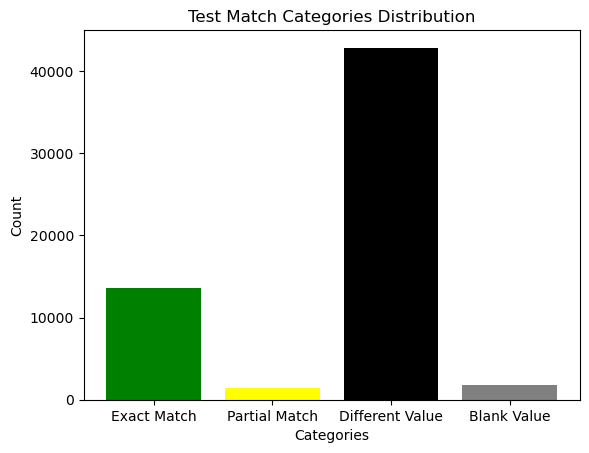

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'Exact_match_with_synonyms_combined_final.xlsx'
data = pd.read_excel(file_path)

# Define the conditions for each category
exact_match = data[(data['Test_Match_Percentage'] == 1)]
partial_match = data[(data['Test_Match_Percentage'] > 0) & (data['Test_Match_Percentage'] < 1)]
different_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].notnull()) & (data['Headers_1_updated'] != '')]
blank_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].isnull() | (data['Headers_1_updated'] == ''))]

# Count the number of rows in each category
categories = {
    'Exact Match': exact_match.shape[0],
    'Partial Match': partial_match.shape[0],
    'Different Value': different_value.shape[0],
    'Blank Value': blank_value.shape[0]
}

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(categories.keys(), categories.values(), color=['green', 'yellow', 'black', 'grey'])

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Test Match Categories Distribution')

# Display the bar chart
plt.show()


In [7]:
import pandas as pd

# Load the Value_corrected_data.xlsx file instead of TEST SCORE UPD.csv
value_corrected_path = 'Value_corrected_data.xlsx'  # Update this path if necessary
updated_output_path = 'Exact_match_with_synonyms_1.csv'  # Update this path if necessary

# Load the Excel and CSV files
value_corrected_df = pd.read_excel(value_corrected_path)
updated_output_df = pd.read_csv(updated_output_path)

# Print the column names to check for discrepancies
print("Value Corrected Data Columns:")
print(value_corrected_df.columns)

print("\nUpdated Output Columns:")
print(updated_output_df.columns)

# Define the columns to process
columns_to_process = ["Security", "Conformity", "Tradition", "Benevolence", "Universalism", 
                      "Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power"]

# Merge dataframes based on 'Text-ID' and 'Sentence-ID'
merged_df = value_corrected_df.merge(updated_output_df, on=['Text-ID', 'Sentence-ID'], suffixes=('_test', '_updated'))

# Function to handle headers based on the value: -1 adds a prefix, others remain the same
def find_headers(row, suffix):
    return ','.join([f"prefix_{col}" if row[f"{col}{suffix}"] == -1 else col 
                     for col in columns_to_process if row[f"{col}{suffix}"] in [-1, 1]])

# Add new columns for headers with the required logic
merged_df['Headers_1_test'] = merged_df.apply(lambda row: find_headers(row, '_test'), axis=1)
merged_df['Headers_1_updated'] = merged_df.apply(lambda row: find_headers(row, '_updated'), axis=1)

# Reorder columns
final_columns = ['Text-ID', 'Sentence-ID'] + \
                [f"{col}_test" for col in columns_to_process] + \
                [f"{col}_updated" for col in columns_to_process] + \
                ['Headers_1_test', 'Headers_1_updated']

final_df = merged_df[final_columns]

# Save to a new Excel file
output_excel_path = 'Exact_match_with_synonyms_combined.xlsx'  # Update this path if necessary
final_df.to_excel(output_excel_path, index=False)

print("Updated file saved as:", output_excel_path)
final_df.head()


Value Corrected Data Columns:
Index(['Text-ID', 'Sentence-ID', 'Security', 'Conformity', 'Tradition',
       'Benevolence', 'Universalism', 'Self-Direction', 'Stimulation',
       'Hedonism', 'Achievement', 'Power'],
      dtype='object')

Updated Output Columns:
Index(['Text-ID', 'Sentence-ID', 'Security', 'Conformity', 'Tradition',
       'Benevolence', 'Universalism', 'Self-Direction', 'Stimulation',
       'Hedonism', 'Achievement', 'Power'],
      dtype='object')
Updated file saved as: Exact_match_with_synonyms_combined.xlsx


,Text-ID,Sentence-ID,Security_test,Conformity_test,Tradition_test,Benevolence_test,Universalism_test,Self-Direction_test,Stimulation_test,Hedonism_test,...,Tradition_updated,Benevolence_updated,Universalism_updated,Self-Direction_updated,Stimulation_updated,Hedonism_updated,Achievement_updated,Power_updated,Headers_1_test,Headers_1_updated
0,BG_002,1,0,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,prefix_Conformity,Self-Direction
1,BG_002,2,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,prefix_Conformity,
2,BG_002,3,0,-1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,"prefix_Conformity,Hedonism","Conformity,Benevolence,Power"
3,BG_002,4,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,prefix_Conformity,Conformity
4,BG_002,5,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,prefix_Conformity,Achievement


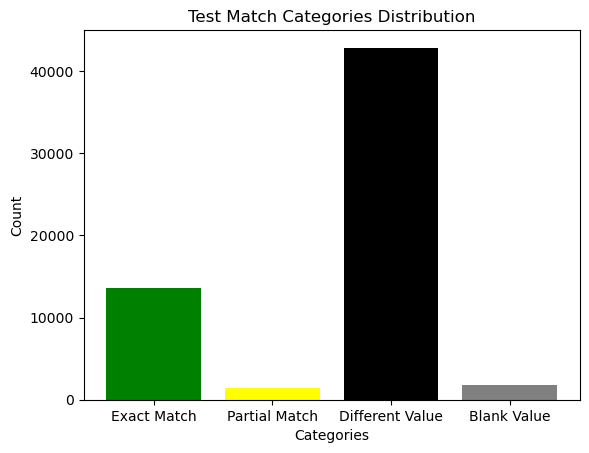

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'Exact_match_with_synonyms_combined_final.xlsx'
data = pd.read_excel(file_path)

# Define the conditions for each category
exact_match = data[(data['Test_Match_Percentage'] == 1)]
partial_match = data[(data['Test_Match_Percentage'] > 0) & (data['Test_Match_Percentage'] < 1)]
different_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].notnull()) & (data['Headers_1_updated'] != '')]
blank_value = data[(data['Test_Match_Percentage'] == 0) & (data['Headers_1_updated'].isnull() | (data['Headers_1_updated'] == ''))]

# Count the number of rows in each category
categories = {
    'Exact Match': exact_match.shape[0],
    'Partial Match': partial_match.shape[0],
    'Different Value': different_value.shape[0],
    'Blank Value': blank_value.shape[0]
}

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(categories.keys(), categories.values(), color=['green', 'yellow', 'black', 'grey'])

# Add labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Test Match Categories Distribution')

# Display the bar chart
plt.show()
